In [431]:
import pandas as pd
import requests
from geopy.geocoders import ArcGIS
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import seaborn as sns
import scipy.stats as stats
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import Lasso, Ridge
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Парсинг данных

In [2]:
data=pd.read_excel('Reestr.xlsx',skiprows=2)

In [4]:
data=data[data['Тип субъекта']=='Юридическое лицо']
data=data[data['Основной вид деятельности']=='41.20 Строительство жилых и нежилых зданий']

In [135]:
data

,№ п/п,Наименование / ФИО,Тип субъекта,Категория,ОГРН,ИНН,Основной вид деятельности,Регион,Район,Город,...,Дата исключения из реестра,Телефон,E-mail,WWW,Наличие лицензий,"Наличие заключенных договоров, контрактов","Производство инновационной, высокотехнологичной продукции",Участие в программах партнерства,Является социальным предприятием,Среднесписочная численность работников за предшествующий календарный год
0,1,""" МЕГАПОЛИС "" ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВ...",Юридическое лицо,Не является субъектом МСП,1027800523376,7801190028,41.2 Строительство жилых и нежилых зданий,78 - г.Санкт-Петербург,NaN,NaN,...,10.10.2021,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,NaN
1,2,""" СТАЛЬИНВЕСТСТРОЙ "" ОБЩЕСТВО С ОГРАНИЧЕННОЙ О...",Юридическое лицо,Не является субъектом МСП,1037800033545,7801227976,41.20 Строительство жилых и нежилых зданий,78 - г.Санкт-Петербург,NaN,NaN,...,10.08.2018,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603518,603519,ЯЩУРИНСКАЯ НАТАЛЬЯ ПЕТРОВНА,Индивидуальный предприниматель,Не является субъектом МСП,318507400035652,370305350203,41.20 Строительство жилых и нежилых зданий,50 - Московская область,NaN,ГОРОД СЕРПУХОВ,...,10.08.2020,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,NaN
603519,603520,CЕЛЬСКОХОЗЯЙСТВЕННЫЙ ПРОИЗВОДСТВЕННЫЙ КООПЕРАТ...,Юридическое лицо,Не является субъектом МСП,1021500979103,1512011462,41.20 Строительство жилых и нежилых зданий,15 - Республика Северная Осетия - Алания,Пригородный р-н,NaN,...,10.08.2017,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,NaN


In [4]:
def getinfo(id):
    
    cookies = {
    '_ym_uid': '1723576771518956905',
    '_ym_d': '1723576771',
    '_ym_isad': '2',
    }

    headers = {
    'Accept': '*/*',
    'Accept-Language': 'ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7',
    'Connection': 'keep-alive',
    'Referer': 'https://bo.nalog.ru/organizations-card/9086367/bfo',
    'Sec-Fetch-Dest': 'empty',
    'Sec-Fetch-Mode': 'cors',
    'Sec-Fetch-Site': 'same-origin',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36',
    'sec-ch-ua': '"Not)A;Brand";v="99", "Google Chrome";v="127", "Chromium";v="127"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    }

    response = requests.get(f'https://bo.nalog.ru/nbo/organizations/{id}/bfo/', cookies=cookies, headers=headers)
    if response.status_code!=200:
        return pd.DataFrame(columns=['period','correction.financialResult.current2110','correction.financialResult.current2400','correction.financialResult.current2330','correction.financialResult.current2410','organizationInfo.address','correction.balance.current1600','correction.balance.current1300','correction.balance.current1700','id'])
    d=pd.json_normalize(response.json())
    cols=['correction.financialResult.current2110','correction.financialResult.current2400','correction.financialResult.current2330','correction.financialResult.current2410','organizationInfo.address','correction.balance.current1600','correction.balance.current1300','correction.balance.current1700']
    for col in cols:
        if col not in d.columns:
            if col=='correction.balance.current1300':
                d[col] = 0
            else:
                return pd.DataFrame(columns=['period','correction.financialResult.current2110','correction.financialResult.current2400','correction.financialResult.current2330','correction.financialResult.current2410','organizationInfo.address','correction.balance.current1600','correction.balance.current1300','correction.balance.current1700','id'])
    d=d[['period','correction.financialResult.current2110','correction.financialResult.current2400','correction.financialResult.current2330','correction.financialResult.current2410','organizationInfo.address','correction.balance.current1600','correction.balance.current1300','correction.balance.current1700']]
    d['id']=[id]*len(d)
    d=d.dropna()
    return d

In [471]:
INN=list(data['ИНН'].values)
for inn in INN[:len(INN)]:
    session=requests.Session()
    headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36"
    }
    res=session.get(f"https://bo.nalog.ru/advanced-search/organizations/search?query={inn}&page=0", headers=headers)
    if res.status_code!=200:
        continue
    try:
        org_id=res.json()['content'][0]['id']
    except:
        continue
    print(inn)
    DF=pd.concat([DF,getinfo(org_id)],ignore_index=True)
    break

7801190028


NameError: name 'DF' is not defined

## Предварительная обработка данных

In [168]:
df=pd.read_csv('output55.csv')

In [169]:
df.columns=['year','revenue','net profit',"interests to pay","income tax",'address','actives','capital','passives','id']
df=df.drop_duplicates()

In [170]:
df[(df['net profit']<0) & (df['net profit']<0)]

,year,revenue,net profit,interests to pay,income tax,address,actives,capital,passives,id
0,2023,108966.0,-20913.0,3334.0,-248.0,"141206, Московская обл, ул Чехова, 12, офис 901",804911.0,606621.0,804911.0,5872486
3,2020,303726.0,-8543.0,23013.0,-310.0,"141206, Московская обл, ул Чехова, 12, офис 901",1121812.0,604937.0,1121812.0,5872486
4,2019,341732.0,-20438.0,35138.0,-925.0,"141206, Московская обл, р-н Пушкинский, г Пушк...",1450125.0,613480.0,1450125.0,5872486
9,2019,27867.0,-3422.0,1234.0,1593.0,"140093, Московская обл, Дзержинский г, Лесная ...",65707.0,21176.0,65707.0,5974422
16,2019,1154.0,-63179.0,24020.0,15727.0,"140007, Московская обл, г Люберцы, ул 8 Марта,...",2479459.0,151667.0,2479459.0,9510572
...,...,...,...,...,...,...,...,...,...,...
52840,2023,326663.0,-516607.0,9828.0,127858.0,"694020, Сахалинская обл, г.о. Корсаковский, г ...",395924.0,-455461.0,395924.0,7005901
52851,2020,1576.0,-3267.0,0.0,0.0,"643,353456,23,Анапский р-н,Анапа г,,Симферопол...",20897.0,20233.0,20897.0,6785064
52852,2019,1339.0,-3374.0,0.0,0.0,"643,353456,23,Анапский р-н,Анапа г,,Симферопол...",24219.0,23551.0,24219.0,6785064
52865,2021,55.0,-1772.0,0.0,2.0,"643,352800,23,Туапсинский р-н,Туапсе г,,Б. Хме...",6173.0,5458.0,6173.0,1009808


In [171]:
df['income tax']=abs(df['income tax'])

In [172]:
mask=(df['net profit']==0) & (df['interests to pay']==0) & (df['income tax']==0)
mask2=(df['revenue']==0) | (df['capital']==0) | (df['actives']==0)
df=df[~mask]
df=df[~mask2]

## Метрики

In [173]:
df['EBIT']=df['net profit']+df['income tax']+df['interests to pay']
df['obligations']=df['passives']-df['capital']
df['Debt-to-Equity'] = df['passives'] / df['capital']
df['ROA'] = (df['net profit'] / df['actives']) * 100

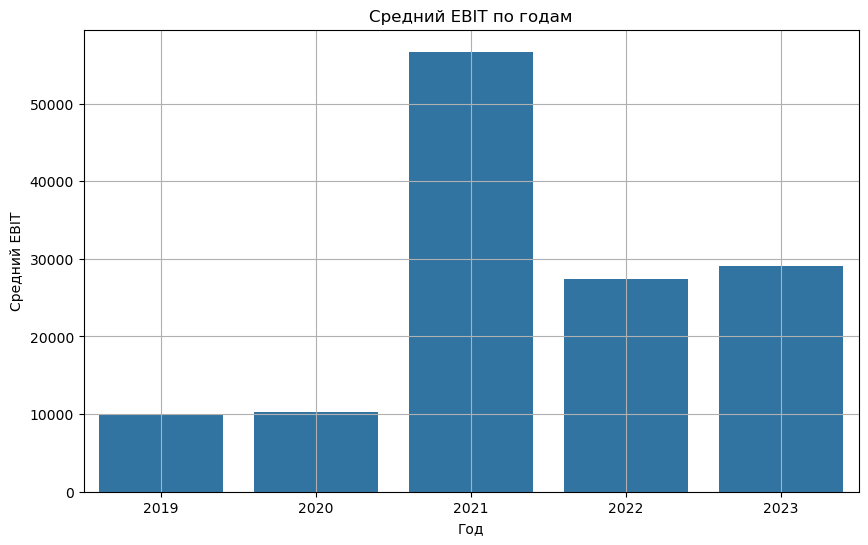

In [174]:
df_grouped = df.groupby('year')['EBIT'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='EBIT', data=df_grouped, ci=None)
plt.title('Средний EBIT по годам')
plt.xlabel('Год')
plt.ylabel('Средний EBIT')
plt.grid(True)
plt.show()

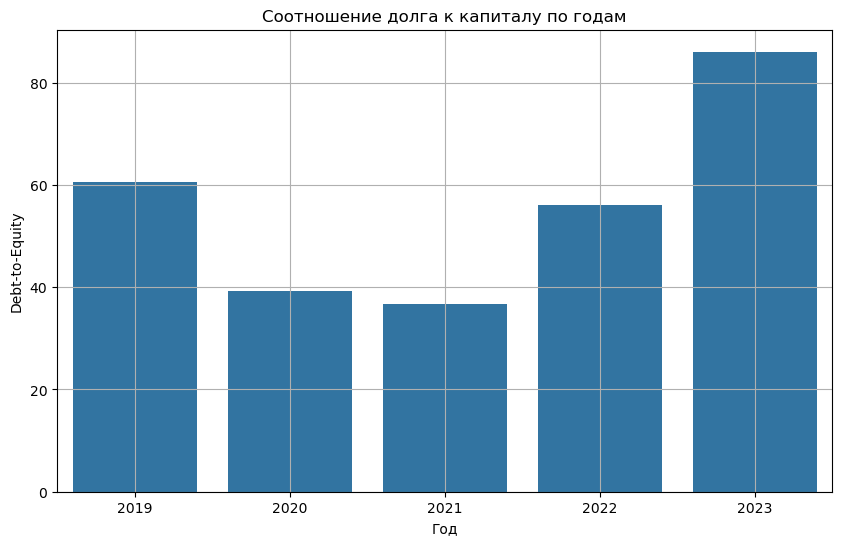

In [175]:
df_grouped = df.groupby('year')['Debt-to-Equity'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='Debt-to-Equity', data=df_grouped, ci=None)
plt.title('Соотношение долга к капиталу по годам')
plt.xlabel('Год')
plt.ylabel('Debt-to-Equity')
plt.grid(True)
plt.show()

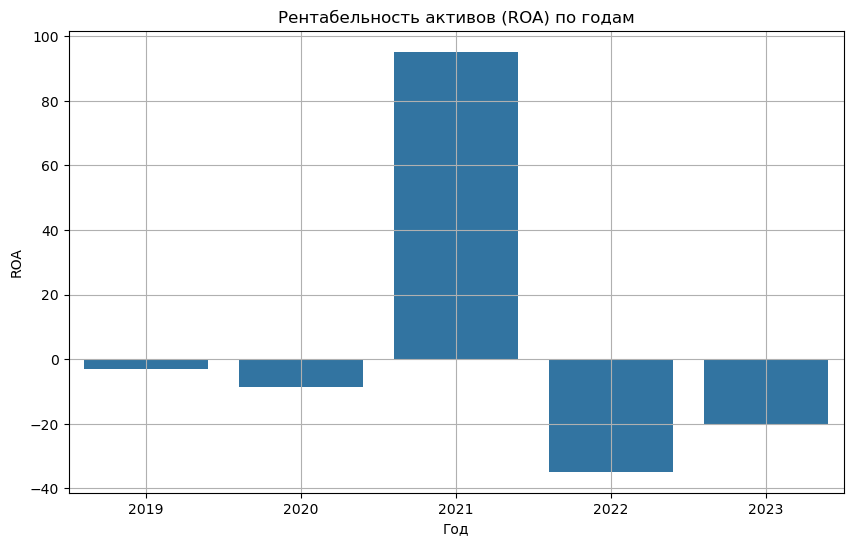

In [176]:
df_grouped = df.groupby('year')['ROA'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='ROA', data=df_grouped, ci=None)
plt.title('Рентабельность активов (ROA) по годам')
plt.xlabel('Год')
plt.ylabel('ROA')
plt.grid(True)
plt.show()

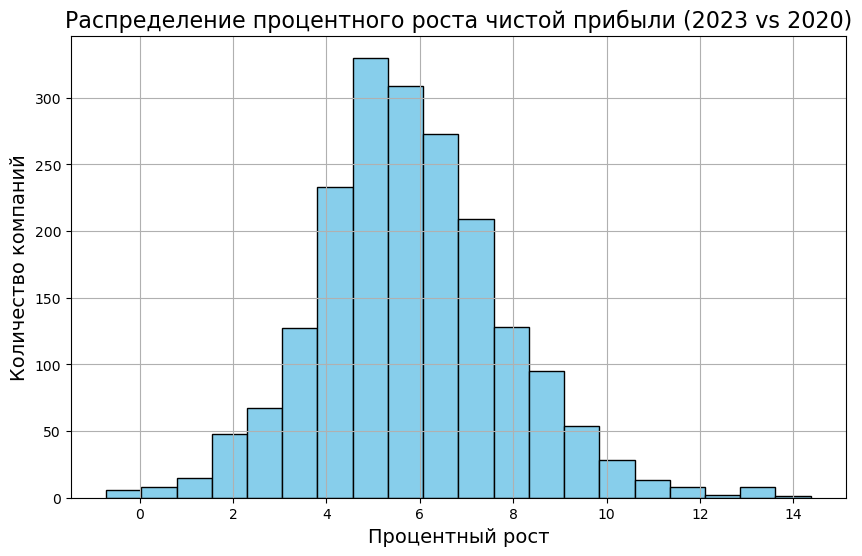

In [177]:
df_filtered = df[df['year'].isin([2020, 2023])]

def calculate_profit_growth(group):
    profit_2023 = group.loc[group['year'] == 2023, 'net profit']
    profit_2020 = group.loc[group['year'] == 2020, 'net profit']
    
    if not profit_2023.empty and not profit_2020.empty:
        profit_2023 = profit_2023.values[0]
        profit_2020 = profit_2020.values[0]
        
        if profit_2020 != 0:
            growth = ((profit_2023 - profit_2020) / profit_2020) * 100
            return pd.Series({'id': group['id'].iloc[0], 'profit_growth_2023_vs_2020': growth})
    
    return None

result = df_filtered.groupby('id').apply(calculate_profit_growth).dropna()
log_data = np.log1p(result['profit_growth_2023_vs_2020'])
plt.figure(figsize=(10, 6))
plt.hist(log_data, bins=20, color='skyblue', edgecolor='black')

plt.title('Распределение процентного роста чистой прибыли (2023 vs 2020)', fontsize=16)
plt.xlabel('Процентный рост', fontsize=14)
plt.ylabel('Количество компаний', fontsize=14)

plt.grid(True)
plt.show()

## Получение координат местоположений

In [102]:
df['latitude']=0
df['longitude']=0
geolocator_arcgis = ArcGIS()

def get_latitude(address):
    try:
        location = geolocator_arcgis.geocode(address)
        if location:
            return location.latitude
        else:
            return None
    except Exception as e:
        print(f"Ошибка для адреса {address}: {e}")
        return None

def get_longitude(address):
    try:
        location = geolocator_arcgis.geocode(address)
        if location:
            return location.longitude
        else:
            return None
    except Exception as e:
        print(f"Ошибка для адреса {address}: {e}")
        return None

f= df['address'][50000:len(df)].apply(get_latitude)
k = df['address'][50000:len(df)].apply(get_longitude)

In [103]:
df['latitude'][50000:len(df)]=f
df['longitude'][50000:len(df)]=k

In [178]:
df2=pd.read_csv('output2.csv')
df2=df2.drop_duplicates()

In [472]:
df2_new=df2[df2['longitude']!=0]
df2_new['income tax']=abs(df2_new['income tax'])
mask=(df2_new['net profit']==0) & (df2_new['interests to pay']==0) & (df2_new['income tax']==0)
mask2=(df2_new['revenue']==0) | (df2_new['capital']==0) | (df2_new['actives']==0)
df2_new=df2_new[~mask]
df2_new=df2_new[~mask2]
df2_new['EBIT']=df2_new['net profit']+df2_new['income tax']+df2_new['interests to pay']
df2_new['obligations']=df2_new['passives']-df2_new['capital']
df2_new['Debt-to-Equity'] = df2_new['passives'] / df2_new['capital']
df2_new['ROA'] = (df2_new['net profit'] / df2_new['actives']) * 100
df_of_top500=df2_new.sort_values(by='revenue',ascending=False)[:500][['latitude','longitude']]


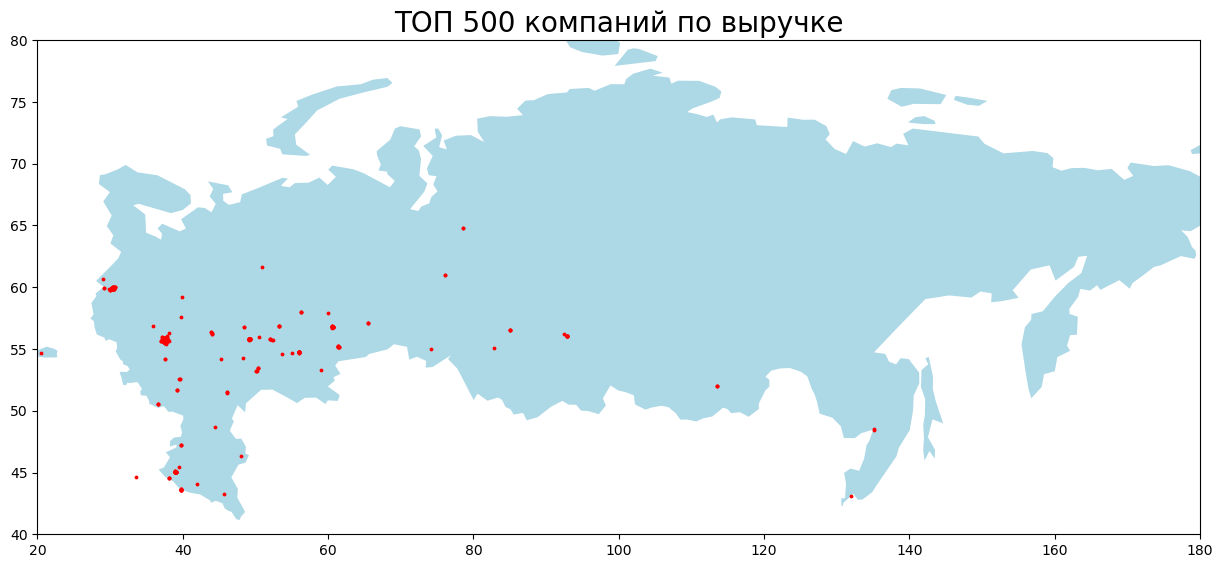

In [180]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
df_of_top500['geometry'] = df_of_top500.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gdf = gpd.GeoDataFrame(df_of_top500, geometry='geometry')
gdf.set_crs(epsg=4326, inplace=True)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

russia = world[world['name'] == 'Russia']

fig, ax = plt.subplots(figsize=(15, 15))  
russia.plot(ax=ax, color='lightblue')

gdf.plot(ax=ax, marker='o', color='red', markersize=3)
ax.set_xlim(20, 180)  
ax.set_ylim(40, 80)   

plt.title("ТОП 500 компаний по выручке", fontsize=20)
plt.show()

## Получение городов для компаний и ещё одного признака

In [154]:
for id in df.id.unique():
    session=requests.Session()
    headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36"
    }
    res=session.get(f"https://bo.nalog.ru/nbo/organizations/{id}/bfo/", headers=headers)
    inn=int(res.json()[0]['organizationInfo']['inn'])
    data[data['ИНН']==inn]

5038038838

In [181]:
pd.set_option('display.max_rows', 10) 

In [192]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="geoapiExercises")

def get_city(latitude, longitude):
    try:
        location = geolocator.reverse((latitude, longitude), language='en')
        address = location.raw.get('address', {})
        city = address.get('city', address.get('town', address.get('village', 'Unknown')))
        return city
    except:
        return 'Unknown'

df2_new['city'] = df2_new.apply(lambda row: get_city(row['latitude'], row['longitude']), axis=1)

print(df2_new[['latitude', 'longitude', 'city']].head())

    latitude  longitude      city
0  56.008705  37.851908  Pushkino
1  56.008705  37.851908  Pushkino
2  56.008705  37.851908  Pushkino
3  56.008705  37.851908  Pushkino
4  55.993094  37.804641  Pushkino


## A/B тест о влиянии местоположения компании

In [196]:
df2_new.to_csv('output3.csv',index=False)

In [272]:
df3=pd.read_csv('output3.csv')
df3=df3[df3['city']!='Unknown']

In [324]:
large_cities = ['Moscow', 'Saint Petersburg', 'Novosibirsk', 'Yekaterinburg', 'Kazan', 
                'Nizhny Novgorod', 'Krasnodar', 'Krasnoyarsk', 'Perm', 'Ufa', 
                'Chelyabinsk', 'Rostov-on-Don', 'Voronezh', 'Samara', 'Omsk', 'Volgograd']
df3['is_large_city'] = df3['city'].apply(lambda x: 1 if x in large_cities else 0)
metrics = ['EBIT', 'Debt-to-Equity', 'ROA']  
df_grouped = df3.groupby('is_large_city')[metrics].mean().reset_index()
large_city_companies = df3[df3['is_large_city'] == 1]['EBIT']
other_city_companies = df3[df3['is_large_city'] == 0]['EBIT']

Shapiro-Wilk Test: Statistic=0.015262961387634277, p-value=0.0


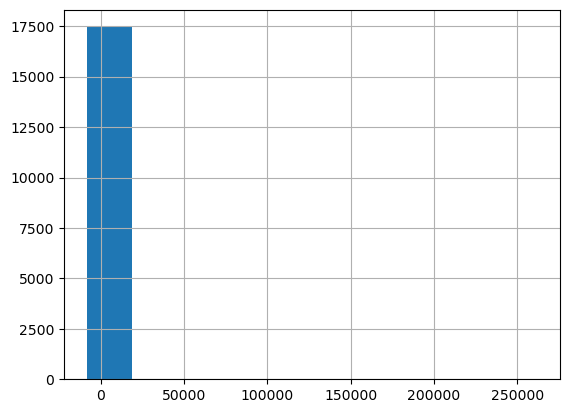

In [274]:
large_city_companies.hist()
shapiro_test = stats.shapiro(large_city_companies)
print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")

In [269]:
u_statistic, p_value_mannwhitney = stats.mannwhitneyu(large_city_companies, other_city_companies)

print(f"Mann-Whitney U Test: U-statistic={u_statistic}, p-value={p_value_mannwhitney}")

if p_value_mannwhitney < 0.05:
    print("Существуют статистически значимые различия в EBIT между компаниями в крупных и остальных городах.")
else:
    print("Нет статистически значимых различий в EBIT между компаниями в крупных и остальных городах.")

Mann-Whitney U Test: U-statistic=171803695.0, p-value=4.208952917577422e-12
Существуют статистически значимые различия в EBIT между компаниями в крупных и остальных городах.


In [270]:
large_city_companies = df3[df3['is_large_city'] == 'Large City']['ROA']
other_city_companies = df3[df3['is_large_city'] == 'Other City']['ROA']

u_statistic, p_value_mannwhitney = stats.mannwhitneyu(large_city_companies, other_city_companies)

print(f"Mann-Whitney U Test: U-statistic={u_statistic}, p-value={p_value_mannwhitney}")

if p_value_mannwhitney < 0.05:
    print("Существуют статистически значимые различия в EBIT между компаниями в крупных и остальных городах.")
else:
    print("Нет статистически значимых различий в EBIT между компаниями в крупных и остальных городах.")

Mann-Whitney U Test: U-statistic=153401578.0, p-value=1.6076913435259883e-30
Существуют статистически значимые различия в EBIT между компаниями в крупных и остальных городах.


In [271]:
large_city_companies = df3[df3['is_large_city'] == 'Large City']['Debt-to-Equity']
other_city_companies = df3[df3['is_large_city'] == 'Other City']['Debt-to-Equity']

u_statistic, p_value_mannwhitney = stats.mannwhitneyu(large_city_companies, other_city_companies)

print(f"Mann-Whitney U Test: U-statistic={u_statistic}, p-value={p_value_mannwhitney}")

if p_value_mannwhitney < 0.05:
    print("Существуют статистически значимые различия в EBIT между компаниями в крупных и остальных городах.")
else:
    print("Нет статистически значимых различий в EBIT между компаниями в крупных и остальных городах.")

Mann-Whitney U Test: U-statistic=189831835.0, p-value=1.3380203518769467e-137
Существуют статистически значимые различия в EBIT между компаниями в крупных и остальных городах.


In [276]:
mean_lat = df3['latitude'].mean()
mean_lon = df3['longitude'].mean()

df3['region'] = np.where(df3['latitude'] > mean_lat, 'North', 'South')
df3['region'] = np.where(df3['longitude'] > mean_lon, df3['region'] + '_East', df3['region'] + '_West')
df_grouped2 = df3.groupby('region')[['EBIT','ROA', 'Debt-to-Equity']].mean().reset_index()


In [280]:
north_companies = df3[df3['region'].str.contains('North')]['EBIT']
south_companies = df3[df3['region'].str.contains('South')]['EBIT']

u_statistic, p_value_mannwhitney = stats.mannwhitneyu(north_companies, south_companies)

print(f"Mann-Whitney U Test: U-statistic={u_statistic}, p-value={p_value_mannwhitney}")

if p_value_mannwhitney < 0.05:
    print("Существуют статистически значимые различия в EBIT между компаниями в крупных и остальных городах.")
else:
    print("Нет статистически значимых различий в EBIT между компаниями в крупных и остальных городах.")

Mann-Whitney U Test: U-statistic=145032180.5, p-value=0.3444016365881154
Нет статистически значимых различий в EBIT между компаниями в крупных и остальных городах.


In [281]:
north_companies = df3[df3['region'].str.contains('North')]['ROA']
south_companies = df3[df3['region'].str.contains('South')]['ROA']

u_statistic, p_value_mannwhitney = stats.mannwhitneyu(north_companies, south_companies)

print(f"Mann-Whitney U Test: U-statistic={u_statistic}, p-value={p_value_mannwhitney}")

if p_value_mannwhitney < 0.05:
    print("Существуют статистически значимые различия в EBIT между компаниями в крупных и остальных городах.")
else:
    print("Нет статистически значимых различий в EBIT между компаниями в крупных и остальных городах.")

Mann-Whitney U Test: U-statistic=141644503.0, p-value=5.399870674028991e-06
Существуют статистически значимые различия в EBIT между компаниями в крупных и остальных городах.


In [282]:
north_companies = df3[df3['region'].str.contains('North')]['Debt-to-Equity']
south_companies = df3[df3['region'].str.contains('South')]['Debt-to-Equity']

u_statistic, p_value_mannwhitney = stats.mannwhitneyu(north_companies, south_companies)

print(f"Mann-Whitney U Test: U-statistic={u_statistic}, p-value={p_value_mannwhitney}")

if p_value_mannwhitney < 0.05:
    print("Существуют статистически значимые различия в EBIT между компаниями в крупных и остальных городах.")
else:
    print("Нет статистически значимых различий в EBIT между компаниями в крупных и остальных городах.")

Mann-Whitney U Test: U-statistic=152871359.0, p-value=1.4440788913291471e-13
Существуют статистически значимые различия в EBIT между компаниями в крупных и остальных городах.


## Модели для предсказания revenue

In [463]:
df3=df3[df3['revenue']>=0]
X = df3[['actives', 'obligations', 'is_large_city','year','income tax','interests to pay']]
y = df3['revenue']

In [465]:
def remove_outliers_iqr(df):
    df_no_outliers = df.copy()
    
    for col in df_no_outliers.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df_no_outliers[col].quantile(0.2)
        Q3 = df_no_outliers[col].quantile(0.8)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]
    
    return df_no_outliers

X_no_outliers = remove_outliers_iqr(X)
remaining_indices = X_no_outliers.index

y_no_outliers = y.loc[remaining_indices]

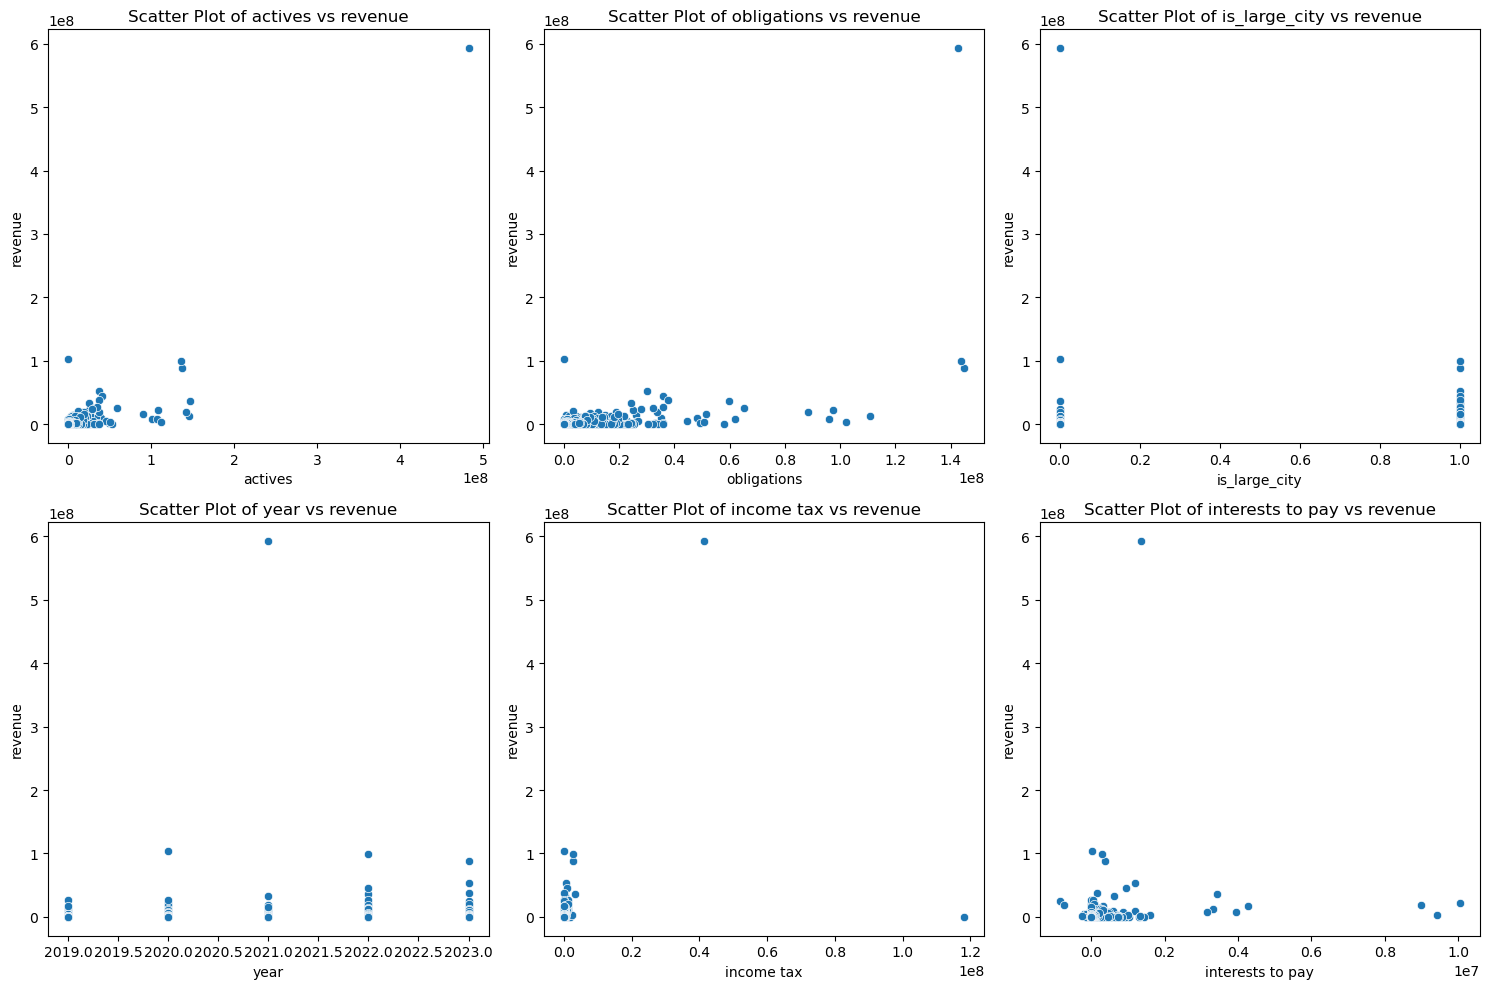

In [466]:
target_column = 'revenue'
features = ['actives', 'obligations', 'is_large_city', 'year', 'income tax', 'interests to pay']
n_features = len(features)

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, (n_features + 1) // 2, i)  
    sns.scatterplot(x=df3[feature], y=df3[target_column])
    plt.title(f'Scatter Plot of {feature} vs {target_column}')
    plt.xlabel(feature)
    plt.ylabel(target_column)

plt.tight_layout()  
plt.show()

In [467]:
X_train, X_test, Y_train, Y_test = train_test_split(X_no_outliers, y_no_outliers, test_size=0.3)

In [468]:
pipeline_gb = Pipeline([
    ('scaler', StandardScaler()),  
    ('gb', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42))
])

pipeline_gb.fit(X_train,Y_train)
y_pred_gb = pipeline_gb.predict(X_test)

mse_gb = mean_squared_error(Y_test, y_pred_gb)
r2_gb = r2_score(Y_test, y_pred_gb)
print(f"Gradient Boosting - Mean Squared Error: {mse_gb}, R2: {r2_gb}")

Gradient Boosting - Mean Squared Error: 5131157001.261919, R2: 0.36689877229658496


In [469]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('lasso', Lasso(alpha=0.1))    
])

pipeline.fit(X_train, Y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(Y_test,y_pred)
r2=r2_score(Y_test,y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R2: {r2}")

Mean Squared Error: 4816515871.9412775
R2: 0.40572036462164884


In [470]:
from sklearn.preprocessing import PolynomialFeatures

pipeline_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=0.1))
])

pipeline_poly.fit(X_train, Y_train)
y_pred_poly = pipeline_poly.predict(X_test)

mse_poly = mean_squared_error(Y_test, y_pred_poly)
r2_poly = r2_score(Y_test, y_pred_poly)
print(f"Polynomial Ridge - Mean Squared Error: {mse_poly}, R2: {r2_poly}")

Polynomial Ridge - Mean Squared Error: 4588671684.601268, R2: 0.4338326275468667


In [ ]:
#Данные признаки плохо подходят для revenue